## 数据预处理

计划达到几个目的：
1. 提取有用字段
2. 数据去重
2. 插补缺失项
3. 将数据按仪器类型分开
4. 分类特征合并
4. 文本数据正则化
4. ETL后样本存入数据库

### 数据读取

In [1]:
import pandas as pd
import numpy as np

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.simplefilter('ignore')

import sys
sys.path.extend(['../src/'])

from config import *

import matplotlib.pyplot as plt
import seaborn as sns

from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

% matplotlib inline

config = Config()

data = {}
for file in ['2015-2018维修数据_部分.xlsx', '2017维修数据.xlsx', '2018维修数据.xlsx']:
    data[file] = pd.read_excel('{}{}'.format(config.origin_data_filepath, file))

data_ = pd.concat(data).reset_index(drop = True)[data['2015-2018维修数据_部分.xlsx'].columns]

### 提取有用字段、分类特征合并

#### 紧急程度字段

紧急程度这个字段为我们提供的信息是故障问题的定义
即什么样的部件故障是可以被评价为紧急故障

一种处理方式是紧急重要合并，其他全部当成正常。但是必存在很多偏差，
而且这列的缺失率较大。这部分信息尽量使用其他特征提取得出
最好的方式应该是，通过一部分样本定义哪些部件故障是紧急故障，然后其他同类故障样本用这个模式插补。

In [4]:
data_['紧急程度'].value_counts()

正常       1560
紧急        841
一般        680
无要求       587
重要        400
1个工作日     207
2个工作日     136
3个工作日      37
郭帅          2
王老师         1
潘婷          1
Name: 紧急程度, dtype: int64

In [2]:
data_.loc[-data_['紧急程度'].isin(['正常', '紧急', '重要', '无要求']), '紧急程度'] = '未知'

In [3]:
data_['紧急程度'].value_counts()

未知     4445
正常     1560
紧急      841
无要求     587
重要      400
Name: 紧急程度, dtype: int64

#### 维修服务内容

In [4]:
service_content = {'维修':'维修', '仪器故障处理':'维修', '更换配件':'维修', 
                   '仪器维护保养':'维护保养', '维护':'维护保养', '年度维护':'维护保养',
                   '项目例行巡检':'巡检','巡检':'巡检',
                   '设备性能验证':'性能验证','性能验证':'性能验证',
                   '移机':'装机/移机', '搬迁':'装机/移机','搬迁调试':'装机/移机','装机调试':'装机/移机','装机调试':'装机/移机',
                   '软件问题处理':'其他','数据分析':'其他','试剂盒性能验证':'其他'}

data_['维修服务内容'] = data_['维修服务内容'].replace().map(service_content)

data_['维修服务内容'].fillna('待确认', inplace = True)

#### 设备编号

In [9]:
data_['设备编号'].isnull().sum()

916

设备编号有916个缺失，观察对应设备编号的其他信息 
可以看到对应的编号也是缺失的
可以看到大多是时间较早的样本，缺失过多
这种情况只能通过客户名称来对应仪器型号把这个缺失值插补掉

##### 设备编号统计

In [6]:
data_equip = data_.drop_duplicates(subset = '设备编号', keep = 'last')

pd.options.display.max_rows = 1200
data_equip['装机日期'] = pd.to_datetime(data_equip['装机日期'], errors = 'coerce')

# data_equip[['客户名称', '设备编号', '设备型号', '主机序列号','装机日期']].sort_values(by = '客户名称')

In [7]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://%s:%s@%s:3306/%s?charset=utf8' %(config.sql_user, config.sql_password, config.sql_ip, config.sql_database),echo = False)
data_equip[['客户名称', '设备编号', '设备型号', '主机序列号','装机日期']].sort_values(by = '客户名称').to_sql('equipment_id', engine, if_exists='replace',index= False)

可以看到设备型号的原始数据里有些模块如1296-003可能是其他大仪器的小部件，存在标记不明确的问题，不利于我们按照设备对数据分类，需要与维修工程师沟通让他们补充修正这部分信息

还有一个思路是，观察到设备编号的抬头一共有几种：  

BS应该是博圣，PE是PE公司  
设备编号和设备型号没准有某种对应关系

另外观察设备编号可以看到，编号并不是完全连续的，比如有BS-2004-PKI-VD-02却没见到BS-2004-PKI-VD-01，这有多种可能性，有可能是这台仪器没有对应的维修报告，顺便维护，没有大修。也有可能是早期就已经淘汰，这一问题在我们定义每台仪器现在的状态的时候，是很必要的。

定义设备型号是要解决几个问题：
1. 存在部分样本设备型号缺失的情况，这部分缺失型号的样本对应的是哪台仪器
2. 计划模型的结果为预测下一次仪器维护的时间，需要将训练样本对仪器做分类，设备型号定义了这一分类

#### 日期时间处理

1. 问题发现日期和解决日期是全的，但是服务小时跟上门日期有关，这部分是未知的
2. 缺失了服务小时的样本跟设备编号的缺失是对应的，这部分数据插补较困难，属于下一步的工作，可以先做设备编号全的数据

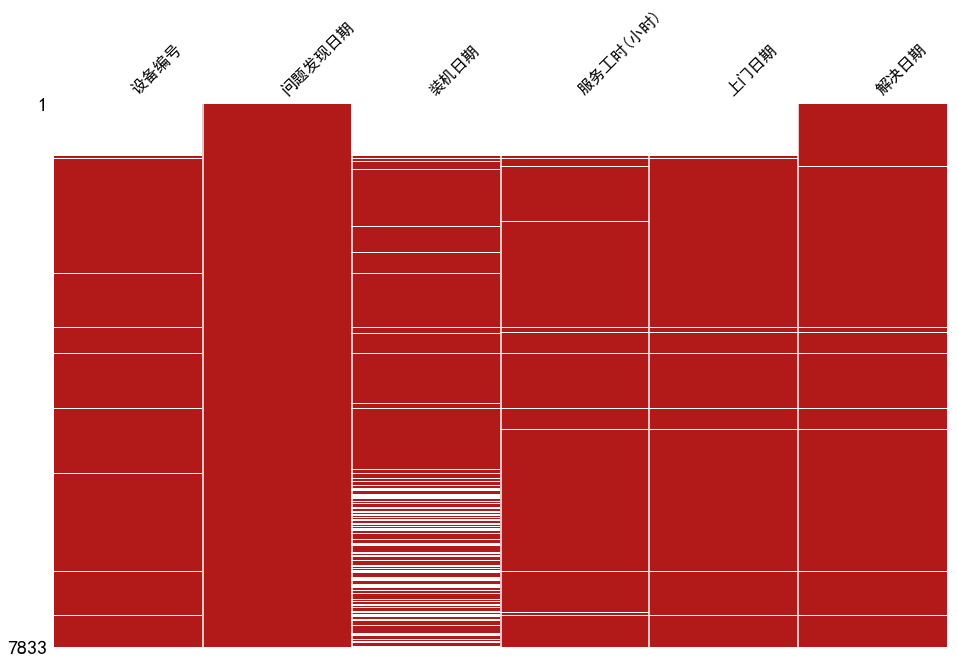

In [8]:
import missingno as msno
msno.matrix(data_[['设备编号','问题发现日期', '装机日期', '服务工时(小时)', '上门日期', '解决日期']],figsize=(16, 10),color=(0.7, 0.1, 0.1),filter='bottom',sparkline=False)

##### 装机日期

In [9]:
zjrq_dict = data_equip['装机日期']
zjrq_dict.index = data_equip['设备编号']
zjrq_dict = zjrq_dict.to_dict()

data = data_.loc[data_['设备编号'].notnull(),:].reset_index(drop = True)

data['装机日期'] = data['设备编号'].map(zjrq_dict)

可以看到使用设备编号的映射来插补装机日期时，也没有多少的改进，大部分缺失的依然是缺失的

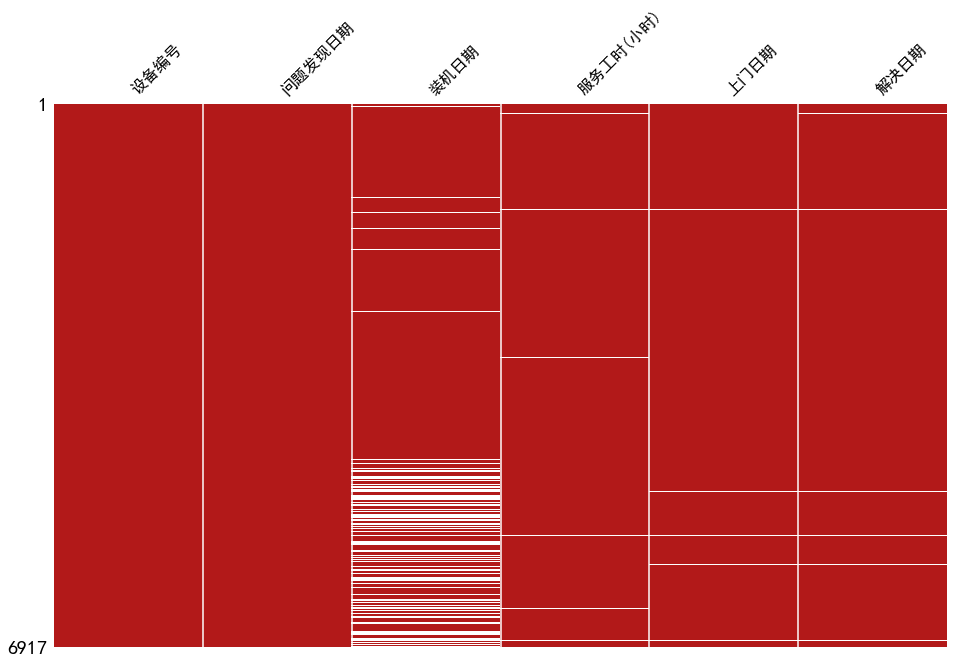

In [10]:
msno.matrix(data[['设备编号','问题发现日期', '装机日期','服务工时(小时)', '上门日期', '解决日期']],figsize=(16, 10),color=(0.7, 0.1, 0.1),filter='bottom',sparkline=False)

接下来用解决日期和上门日期来修正服务小时

可以看到缺失的条数并不多，并且能被插补的也并不多

##### 服务工时

用来衡量问题的解决难度

In [11]:
data.loc[5162,'服务工时(小时)'] = 1
data.loc[6123,'服务工时(小时)'] = 3
data.loc[6124,'服务工时(小时)'] = 0.5
data.loc[6427,'服务工时(小时)'] = 4
data.loc[6721,'服务工时(小时)'] = 3
data.loc[6842,'服务工时(小时)'] = 5.5

##### 服务间隔

用来衡量这个问题的紧急程度，问题可能导致第二天就无法做实验的就会立即派工程师去
这个特征跟客户的重要程度和到客户的距离可能会有关，可以研究一下

还能发现一些脏数据的位置

问题发现日期很多是瞎填的，作为绩效考核指标，所以他们通常会填写上门日期的前几天，所以并不一定是准确的，只能作为参考  
服务单号的日期编码是自动生成的，和报告提交日期一致

In [12]:
data['服务间隔天数'] = (pd.to_datetime(data['上门日期'], errors = 'coerce') - pd.to_datetime(data['问题发现日期'], errors = 'coerce')).apply(lambda x: x.days)

##### 上次维修时间

对于一台设备，上一次维修时间是被记录的，如果只有一条记录，就登记为空

In [13]:
from tqdm import tqdm_notebook

data['上次维修时间'] = data['问题发现日期'].copy()
def last_service(x):
    del x[-1]
    x.insert(0, None)
    return x
for equipment_id in tqdm_notebook(data['设备编号'].unique()):
    cache = list(data.loc[data['设备编号'] == equipment_id, '问题发现日期'])
    if len(cache) <= 1:
        data.loc[data['设备编号'] == equipment_id, '上次维修时间'] = None
    else:
        data.loc[data['设备编号'] == equipment_id, '上次维修时间'] = last_service(cache)

HBox(children=(IntProgress(value=0, max=1189), HTML(value='')))

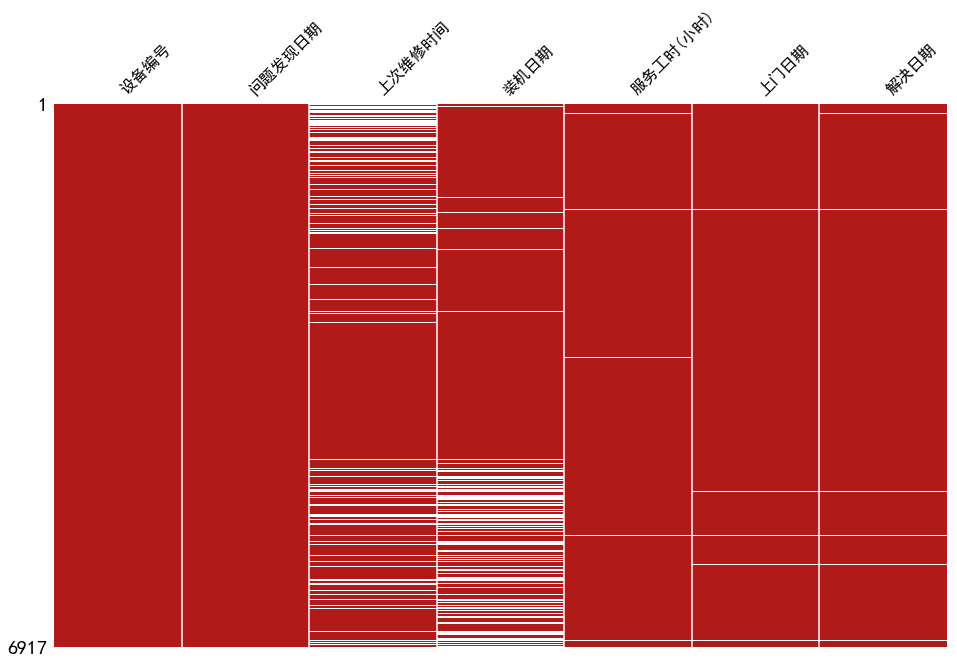

In [121]:
msno.matrix(data[['设备编号','问题发现日期','上次维修时间', '装机日期','服务工时(小时)', '上门日期', '解决日期']],figsize=(16, 10),color=(0.7, 0.1, 0.1),filter='bottom',sparkline=False)

由于很多仪器是刚装的，第一次维修，所以装机日期来替代上次维修时间是合理的
需要考虑的是，第一次新机其实对于相同的问题来说，新机应该是更难坏的，需要留一个标签记录

In [14]:
data['问题发现日期'].min()

Timestamp('2016-06-30 00:00:00')

In [15]:
data['装机日期'] = pd.to_datetime(data['装机日期'], errors = 'coerce')

data.loc[(data['上次维修时间'].isnull())&(data['装机日期'] > '2016-06-30'),'上次维修时间'] = data.loc[(data['上次维修时间'].isnull())&(data['装机日期'] > '2016-06-30'),'装机日期']

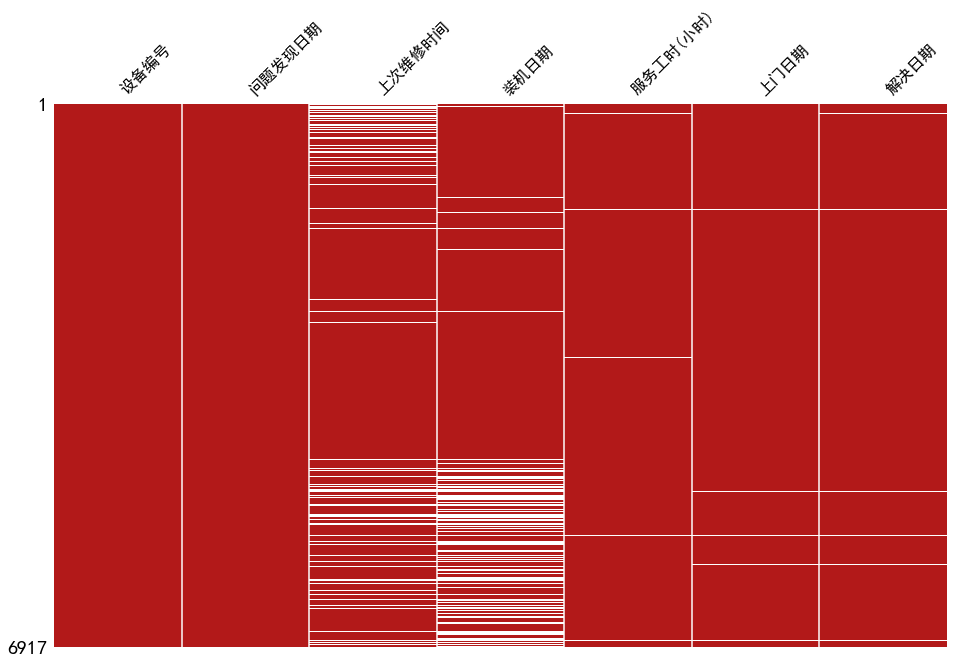

In [124]:
msno.matrix(data[['设备编号','问题发现日期','上次维修时间', '装机日期','服务工时(小时)', '上门日期', '解决日期']],figsize=(16, 10),color=(0.7, 0.1, 0.1),filter='bottom',sparkline=False)

#### 文本处理

In [16]:
import re

def text_clean(content):
    try:
#         result = re.sub(r'[^\u4e00-\u9fa5,A-Za-z0-9]', " ",content)
        result = re.sub('&nbsp;', "",content)
        result = re.sub('<br>', "",result)
        result = re.sub(' ', "",result)
#         result = re.sub('正常', " ",result)
        result = re.sub('\n', "",result)
        result = re.sub('\t', "",result)
    except:
        result = ''
    return result

In [17]:
for col in ['问题描述', '故障描述','服务报告','解决方案','实际问题描述']:
    data[col] = data[col].apply(text_clean)

电脑故障不属于定期维护范围之内，后期可以不做考虑。如serverBusy问题

可以看到问题描述，故障描述，实际问题描述有重复的部分，服务报告解决方案可能也有重复的部分

##### 文本去重 余弦相似性

In [63]:
from jieba import analyse
jieba.load_userdict('../source/words/userdict.txt')

def words2vec(words1=None, words2=None):
    """
    通过分词、计算并集、词频，得出词频向量
    :param words1:
    :param words2:
    :return: 词频的向量
    """
    v1 = []
    v2 = []
    tag1 = analyse.extract_tags(words1, withWeight=True)
    tag2 = analyse.extract_tags(words2, withWeight=True)
    tag_dict1 = {i[0]: i[1] for i in tag1}
    tag_dict2 = {i[0]: i[1] for i in tag2}
    merged_tag = set(tag_dict1.keys()) | set(tag_dict2.keys())
    for i in merged_tag:
        if i in tag_dict1:
            v1.append(tag_dict1[i])
        else:
            v1.append(0)
        if i in tag_dict2:
            v2.append(tag_dict2[i])
        else:
            v2.append(0)
    return v1, v2

def cosine_similarity(vector1, vector2):
    """
    余弦值相似度计算
    :param vector1:
    :param vector2:
    :return:
    """

    dot_product = 0.0
    norm1 = 0.0
    norm2 = 0.0
    for a, b in zip(vector1, vector2):
        dot_product += a * b
        norm1 += a ** 2
        norm2 += b ** 2
    if norm1 == 0.0 or norm2 == 0.0:
        return 0
    else:
        return round(dot_product / ((norm1 ** 0.5) * (norm2 ** 0.5)) * 100, 2)

In [19]:
_data = data.copy()

from tqdm import trange

def cosine_calculator(_data, col1, col2):
    cosine_sim = []
    for i in range(_data.shape[0]):
        w2v1, w2v2 = words2vec(_data[col1][i],_data[col2][i])
        cosine_sim.append(cosine_similarity(w2v1,w2v2))
    return cosine_sim 

def text_col_len(series):
    return series.apply(lambda x: len(x))

def text_concat(data, cut_value, col1, col2):
    _data = data.copy()
    cosine_sim = cosine_calculator(_data, col1, col2)
    _data['cosine_sim'] = cosine_sim
    _data['{}_len'.format(col1)] = text_col_len(_data[col1])
    _data['{}_len'.format(col2)] = text_col_len(_data[col2])
    _data['output'] = None
    _data.loc[_data['cosine_sim'] <=cut_value, 'output'] = _data.loc[_data['cosine_sim'] <=cut_value, col1] + _data.loc[_data['cosine_sim'] <cut_value,col2]
    _data.loc[(_data['cosine_sim'] >cut_value)&(_data['{}_len'.format(col1)] >= _data['{}_len'.format(col2)]), 'output'] = _data.loc[(_data['cosine_sim'] >cut_value)&(_data['{}_len'.format(col1)] >= _data['{}_len'.format(col2)]),col1]
    _data.loc[(_data['cosine_sim'] >cut_value)&(_data['{}_len'.format(col1)] < _data['{}_len'.format(col2)]), 'output'] = _data.loc[(_data['cosine_sim'] >cut_value)&(_data['{}_len'.format(col1)] < _data['{}_len'.format(col2)]),col2]
    return _data['output']

_data['问题汇总1'] = text_concat(_data, 85, '问题描述', '故障描述')
_data['问题汇总'] = text_concat(_data, 85, '问题汇总1', '实际问题描述')

data['问题汇总'] = _data['问题汇总'].copy()
data['解决方案汇总'] = text_concat(data, 85, '服务报告','解决方案')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\KENSHI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.707 seconds.
Prefix dict has been built succesfully.


### 提取有用字段

In [20]:
data.columns

Index(['服务单号', '客户名称', '所在省份', '客户类型', '客户联系人', '紧急程度', '问题发现日期', '问题发现时间',
       '服务部门', '事项 ', '项目类别', '分项内容', '工作方式', '问题描述', '派单主管', '分配工程师', '维修总费用',
       '设备编号', '设备名称', '设备型号', '主机序列号', '装机日期', '维修服务内容', '故障描述', '服务报告',
       '解决方案', '服务工时(小时)', '上门日期', '上门时间', '解决日期', '解决时间', '总结提交日期', '任务星级',
       '实际问题描述', '回访时间', '回访对象', '问题是否解决', '总体满意度', '礼仪/形象', '技能水平', '沟通能力',
       '服务态度', '服务间隔天数', '上次维修时间', '问题汇总', '解决方案汇总'],
      dtype='object')

In [21]:
data_ = data[['服务单号', '客户名称', '客户类型', '紧急程度', '问题发现日期', '分配工程师', 
      '设备编号', '设备型号','服务工时(小时)', '服务间隔天数', '上次维修时间',
      '装机日期', '维修服务内容', '问题汇总', '解决方案汇总']]

data_.to_sql('etl_data', engine, if_exists='replace',index= False)

## 文本挖掘

在做完了传统的数据预处理之后，其他的信息就全部含在文本当中了，  
此时要对文本进行挖掘，提取更多的特征的同时将结构化数据中“待定”和“未知”的缺失信息进行插补

In [2]:
import pandas as pd
import numpy as np
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.simplefilter('ignore')
import sys
sys.path.extend(['../src/'])

from config import *
config = Config()

from wordcloud import WordCloud
import jieba
from jieba import analyse
import re
from tqdm import tqdm
from sqlalchemy import create_engine
from config import Config
import os

engine = create_engine('mysql+pymysql://%s:%s@%s:3306/%s?charset=utf8' %(config.sql_user, config.sql_password, config.sql_ip, config.sql_database),echo = False)
sql = "select * from etl_data"
data = pd.read_sql_query(sql, engine)

In [2]:
data.columns

Index(['服务单号', '客户名称', '客户类型', '紧急程度', '问题发现日期', '分配工程师', '设备编号', '设备型号',
       '服务工时(小时)', '服务间隔天数', '上次维修时间', '装机日期', '维修服务内容', '问题汇总', '解决方案汇总'],
      dtype='object')

In [4]:
pd.DataFrame(data['设备型号'].value_counts())

,设备型号
1235-514,1683
GSL-120,675
2021-0010,594
2081-0010,524
GSL-120/GSL-10,399
GCS3000DX2,393
1235-5220,391
1420-020,389
TQD,353
CDS-5,308


### 修正jieba分词

In [32]:
import jieba.posseg as pseg
jieba.load_userdict('../source/words/userdict.txt')  
# 创建停用词list  
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords    
  
# 对句子进行分词  
def seg_sentence(sentence):  
    sentence_seged = jieba.cut(sentence.strip(), HMM=True, cut_all=False)  
#     sentence_seged = jieba.cut_for_search(sentence.strip(), HMM=True)
    stopwords = stopwordslist('../source/words/中文停用词表.txt')  # 这里加载停用词的路径  
    outstr = ''  
    for word in sentence_seged:  
        if word not in stopwords:  
            if word != '\t':  
                outstr += word  
                outstr += " "  
    return outstr

In [50]:
jieba.load_userdict('../source/words/userdict.txt')

print(data['解决方案汇总'][12])
print(seg_sentence(data['解决方案汇总'][12]))

1、查看近几次实验结果，发现标准曲线荧光值均正常，但质控有几次出控的情况，并且在位置上并无规律。判断其与质控品的吸样和后续的反应步奏有关。检查加样针坐标，发现其在质控品和样本架的坐标偏左严重；校准加样针的各坐标。检查洗针槽比较脏，清洁冲洗洗针槽。检查洗板头，与增强液头，发现针尖上均有厚厚一层结晶，可能会导致交叉污染；清洁并清洗洗板机头和增强液头。检查并校准左右加样枪的静态气压。检查检测平台，发现检测平台通光孔位置有较多污染物，清洁清洁检测平台。结果待第二天观察实验结果2、检查ups，发现内部3个风扇均不转了。亮起的红灯表示ups内部温度过高。将仪器电源暂时接到墙上，拆开ups，取下风扇，待第二天到市场去配。第二天：1、当天仪器实验结果质控正常2、将市场采购的ups轴流风扇更换上，ups运行正常。
查看 近 几次 实验 发现 标准曲线 荧光值 均 正常 质控 几次 出控 情况 位置 无规律 判断 质控 品 吸样 后续 反应 步奏 检查 加样针 坐标 发现 质控 品 样本架 坐标 偏左 严重 校准 加样针 坐标 检查 洗针 槽 比较 脏 清洁 冲洗 洗针 槽 检查 洗板 头 增强液 头 发现 针尖 均 厚厚 一层 结晶 可能 会 导致 交叉 污染 清洁 清洗 洗板机 头 增强液 头 检查 校准 左右 加样枪 静态 气压 检查 检测 平台 发现 检测 平台 通光孔 位置 污染物 清洁 清洁 检测 平台 第二天 观察 实验 检查 ups 发现 内部 风扇 均 转 亮起 红灯 表示 ups 内部 温度过高 仪器 电源 暂时 接到 墙上 拆开 ups 取 风扇 第二天 市场 去配 第二天 当天 仪器 实验 质控 正常 市场 采购 ups 轴流 风扇 更换 ups 运行 正常 


In [69]:
jieba.load_userdict('../source/words/userdict.txt')

print(data['问题汇总'][17])
print(seg_sentence(data['问题汇总'][17]))

按计划执行年度维护维护保养
按计划 执行 年度维护 维护保养 


In [62]:
jieba.load_userdict('../source/words/userdict.txt')
words = pseg.cut(seg_sentence(data['问题汇总'][13]))
for word, flag in words:
    # 格式化模版并传入参数
    print('%s, %s' % (word, flag))

客户, n
 , x
反映, v
 , x
120, m
 , x
仪器, n
 , x
漏油, n
 , x
现象, n
 , x
客户, n
 , x
反映, v
 , x
120, m
 , x
油路, n
 , x
严重, a
 , x
漏油, n
 , x
现象, n
 , x


### 特征插补

#### 紧急程度

紧急程度这个特征的意义在于帮助我们对问题定性

方案：通过提取出已有标签的样本做训练，预测缺失的样本再进行调整  
事实上，很容易出现文本中并不提及重要和紧急的情况

In [25]:
data_['紧急程度'].value_counts()

未知     3580
正常     1533
紧急      836
无要求     584
重要      384
Name: 紧急程度, dtype: int64

可以看到有3580个样本是未知紧急程度的，无要求这个比较难判断情感色彩，作为正常，不紧急来处理  
重要和紧急是两类

In [11]:
def word_cloud_tfidf(data_line, output, save_path):
    data_line_clean = data_line.apply(lambda x: text_clean(x))
    cache = ""
    for i in data_line_clean:
        cache = cache + i
    content = " ".join(jieba.cut(cache))
    key_words = analyse.extract_tags(content, topK=2000, withWeight=True, allowPOS=('nb','n','nr', 'ns','a','ad','an','nt','nz','v','d'))
    textrank = analyse.textrank(content,topK = 200,withWeight = True)
    keywords = dict()
    for i in key_words:
        keywords[i[0]] = i[1]
#     back_coloring = plt.imread(bg_image_path)  # 设置背景图片
    my_wordcloud = WordCloud(
                     background_color = 'white', #背景颜色
                     width=1500,height=960, #图片大小
                     margin=10
                   )
    my_wordcloud.generate_from_frequencies(keywords)
    plt.figure(figsize = (12, 7))
    plt.imshow(my_wordcloud)
    plt.axis("off")
    plt.savefig('{}/{}'.format(save_path, output))

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from wordcloud import WordCloud
import jieba
from jieba import analyse
import re

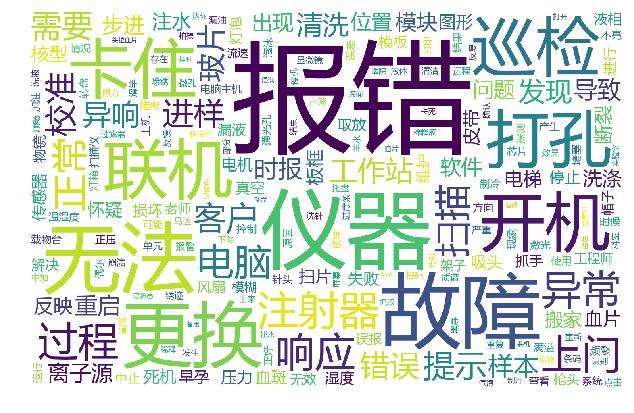

In [15]:
from data_preprocess import text_clean

word_cloud_tfidf(data.loc[data['紧急程度'] == '紧急', '问题汇总'], '紧急问题', config.savefig_path)

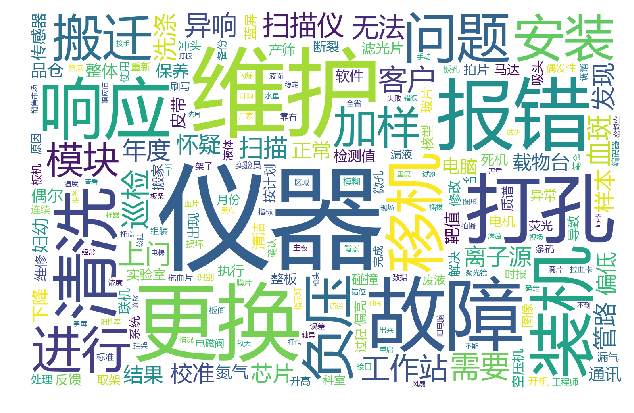

In [29]:
word_cloud_tfidf(data_.loc[data_['紧急程度'] == '重要', '问题汇总'], '重要问题', config.savefig_path)

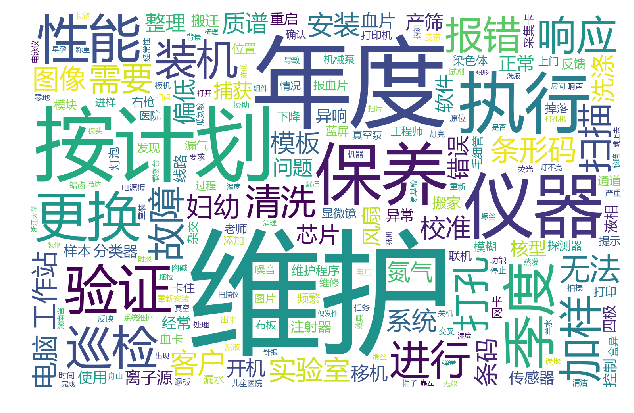

In [30]:
word_cloud_tfidf(data_.loc[data_['紧急程度'] == '正常', '问题汇总'], '正常问题', config.savefig_path)

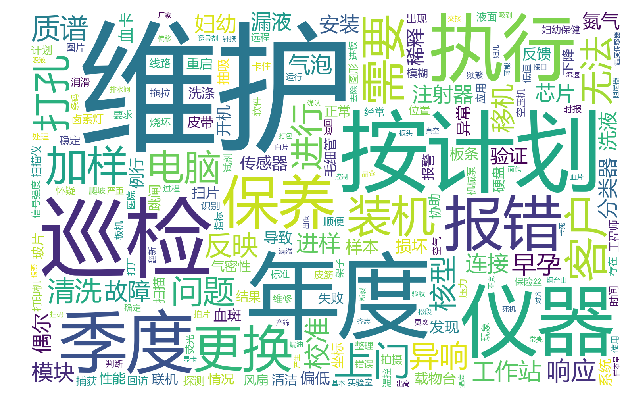

In [31]:
word_cloud_tfidf(data_.loc[data_['紧急程度'] == '无要求', '问题汇总'], '无要求问题', config.savefig_path)